# Assignment 6: Apply NB

<ol>
    <li><strong>Apply Multinomial NB on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    </li>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li></li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
        </ul>
    </li>
    <li>
fine the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using absolute values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print their corresponding feature names
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm_notebook

from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
import joblib
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix,  roc_auc_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [14]:
#colab
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Appliedai colab/donors choose data/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Appliedai colab/donors choose data


In [ ]:
# gcp bucket
# %cd /demo-mount/donors choose data/

[Errno 2] No such file or directory: '/demo-mount/donors choose data/'
/content


In [ ]:
data = pd.read_csv('preprocessed_final.csv',nrows = 50000,index_col = 0) #reading locally using pandas
data = data.drop(['teacher_id','std_price','nrm_price'], axis =1)

# Feature Set 1 - BOW

In [16]:
data.head()

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,Educational Support for English Learners at Home,My students need opportunities to practice beg...,0,0,My students are English learners that are work...,154.60,23
1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,Wanted: Projector for Hungry Learners,My students need a projector to help with view...,7,1,Our students arrive to our school eager to lea...,299.00,1
2,ms,az,grades_6_8,health_sports,health_wellness_teamsports,Soccer Equipment for AWESOME Middle School Stu...,"My students need shine guards, athletic socks,...",1,0,"\r\n\""True champions aren't always the ones th...",516.85,22
3,mrs,ky,grades_prek_2,literacy_language_math_science,literacy_mathematics,Techie Kindergarteners,My students need to engage in Reading and Math...,4,1,I work at a unique school filled with both ESL...,232.90,4
4,mrs,tx,grades_prek_2,math_science,mathematics,Interactive Math Tools,My students need hands on practice in mathemat...,1,1,Our second grade classroom next year will be m...,67.98,4


In [ ]:
#https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
#https://stackoverflow.com/a/54704747/9292995
#https://stackoverflow.com/q/24169238/9292995 If valueError: If any column is negative

text_transformer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)

numeric_features = ['teacher_number_of_previously_posted_projects', 'price', 'quantity']
numeric_transformer = Pipeline(steps=[
  ('scaler', MinMaxScaler())])

categorical_features = ['school_state', 'teacher_prefix', 'project_grade_category','project_subject_categories',\
                      'project_subject_subcategories']
categorical_transformer = Pipeline(steps=[
  ('onehot', OneHotEncoder(handle_unknown='ignore'))])


text_transformer = Pipeline(steps=[
  ('trans', text_transformer)])

preprocessor = ColumnTransformer(
  transformers=[('num', numeric_transformer, numeric_features),
      ('cat', categorical_transformer, categorical_features),
      ('essay', text_transformer, "essay"),
      ('title', text_transformer, "project_title"),
      ('resource', text_transformer, "project_resource_summary")]
  ,n_jobs=-1, verbose=True, remainder = 'drop'
          )

In [ ]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)

In [19]:
%%time
preprocessed_X_BOW =  preprocessor.fit_transform(X)

CPU times: user 7.94 s, sys: 1.83 s, total: 9.77 s
Wall time: 3min 31s


In [23]:
%%time
model = MultinomialNB(class_prior = [0.5, 0.5])

pipeline = Pipeline(steps=[('classifier',  model)])

X_train, X_test, y_train, y_test = train_test_split(preprocessed_X_BOW, y, test_size=0.25, stratify=y, random_state = 42)

pipeline.fit(X_train, y_train)
print("model score: %.3f" % pipeline.score(X_test, y_test))

model score: 0.669
CPU times: user 182 ms, sys: 10.8 ms, total: 193 ms
Wall time: 192 ms


Before setting class_prior = 0.703

After setting class_priors = 0.669

In [24]:
print("model score: %.3f" % pipeline.score(X_train, y_train))

model score: 0.688


In [ ]:
def searchplot(gs, alpha, title):
  # https://stackoverflow.com/a/48803361/4084039
  results = pd.DataFrame.from_dict(gs.cv_results_)

  results = results.sort_values(alpha)
  train_auc= results['mean_train_score']
  train_auc_std= results['std_train_score']
  cv_auc = results['mean_test_score'] 
  cv_auc_std= results['std_test_score']

  K =  results[alpha]

  # plt.xkcd()
  plt.figure()
  plt.xscale('log')
  plt.xlabel('$\\alpha$ (alpha)')
  plt.ylabel("AUC")
  plt.title(title)
  plt.grid()

  plt.plot(K, train_auc, label='Train AUC')
  # plt.gca().fill_between(K, train_auc - train_auc_std, \
  #                        train_auc + train_auc_std, alpha=0.2, \
  #                        color='darkblue')

  plt.plot(K, cv_auc, label='CV AUC')
  # plt.gca().fill_between(K, cv_auc - cv_auc_std, \
  #                        cv_auc + cv_auc_std, alpha=0.2, \
  #                        color='darkorange')

  plt.scatter(K, train_auc, label='Train AUC points')
  plt.scatter(K, cv_auc, label='CV AUC points')

  plt.legend(loc = 'best')
  plt.show()

  results.head()

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

def roc_auc_pipe(clf, X_train, X_test, y_train, y_test, title):
  y_train_pred = clf.predict_proba(X_train)[:,1]
  y_test_pred = clf.predict_proba(X_test)[:,1]
      
  train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
  test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

  plt.close
  plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
  plt.legend()
  plt.plot([0, 1], [0, 1],'g--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.xlabel("False Positive Rate(FPR)")
  plt.ylabel("True Positive Rate(TPR)")
  plt.title(title)
  plt.grid()
  plt.show()

In [42]:
%%time
cv = KFold(3)

param_grid = {
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__fit_prior': [True, False]
}

gs = GridSearchCV(pipeline, param_grid, cv = cv, n_jobs = -1, verbose = 2, return_train_score = True, scoring = "roc_auc")

gs.fit(X_train, y_train)
print("Mean cross-validated score(AUC) of the best_estimator : {0}".format(gs.best_score_))

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.5s


Mean cross-validated score(AUC) of the best_estimator : 0.6992779154392871
CPU times: user 408 ms, sys: 334 ms, total: 743 ms
Wall time: 4.15 s


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    4.1s finished


Before - Mean cross-validated score(AUC) of the best_estimator : 0.6992968471282798

After - 6992779154392871

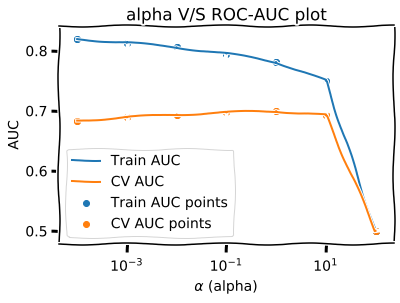

In [73]:
searchplot(gs, alpha = 'param_classifier__alpha', title = 'alpha V/S ROC-AUC plot')

The best hyper parameter which seems be the best fit is c = 10
Because the difference between train and test AUC is minimal

In [35]:
%%time
model = MultinomialNB(alpha = 1)

best_pipeline_BOW = Pipeline(steps=[('classifier',  model)])

X_train, X_test, y_train, y_test = train_test_split(preprocessed_X_BOW, y, test_size=0.25, stratify=y, random_state = 42)

best_pipeline_BOW.fit(X_train, y_train)
print("model score: %.3f" % best_pipeline_BOW.score(X_test, y_test))

model score: 0.703
CPU times: user 172 ms, sys: 22.6 ms, total: 195 ms
Wall time: 194 ms


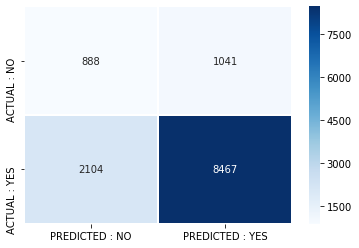

In [37]:
y_pred = cross_val_predict(best_pipeline_BOW, X_test, y_test, cv=3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,  annot=True,  cmap = 'Blues', fmt = 'g', linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES']);

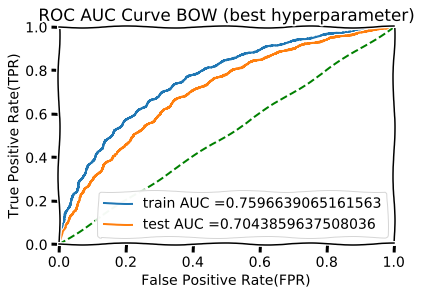

In [74]:
#Trained on Best hyperparameter alpha = 10
roc_auc_pipe(best_pipeline_BOW, X_train, X_test, y_train, y_test, "ROC AUC Curve BOW (best hyperparameter)")

### Top 20 features

In [ ]:
#Most important features in Naive Bayes : https://stackoverflow.com/questions/26976362/how-to-get-most-informative-features-for-scikit-learn-classifier-for-different-c
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=20):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(abs(classifier.feature_log_prob_[0]), feature_names))[:n]
    topn_class2 = sorted(zip(abs(classifier.coef_[0]), feature_names))[-n:]
    print("Top 20 features for class 0")
    print("")
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print('='*50)   
    print("Top 20 features for class 1")
    print("")
    for coef, feat in reversed(topn_class2):
        print (class_labels[1], coef, feat)


In [ ]:
cat_features = preprocessor.named_transformers_['cat'][0].get_feature_names()
title_features = preprocessor.named_transformers_['title'][0].get_feature_names()
essay_features = preprocessor.named_transformers_['essay'][0].get_feature_names()
resource_features = preprocessor.named_transformers_['resource'][0].get_feature_names()

In [ ]:
all_features = [cat_features , essay_features , title_features , resource_features, ['teacher_number_of_previously_posted_projects'],['price'],['quantity']] 
feat_list = [item for sublist in all_features for item in sublist]

In [ ]:
preprocessed_X_BOW.toarray().shape

(50000, 15497)

In [ ]:
df = pd.DataFrame(data = preprocessed_X_BOW.toarray(), columns = feat_list) #Converting the csr to numpy array and creating a dataframe with feature names

In [ ]:
df.head()

,x0_ak,x0_al,x0_ar,x0_az,x0_ca,x0_co,x0_ct,x0_dc,x0_de,x0_fl,...,yoga ball,yoga balls,yoga mats,yoga mats and,you,young,your,teacher_number_of_previously_posted_projects,price,quantity
0,0.000000,0.015397,0.023681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.016355,0.029839,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.002336,0.051628,0.022605,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.009346,0.023228,0.003229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.002336,0.006733,0.003229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
word_vectorizer = CountVectorizer(min_df = 10, ngram_range=(1,4))
word_vectorizer.fit_transform(df)
most_informative_feature_for_binary_classification(word_vectorizer, best_pipeline_BOW.named_steps['classifier'])

Top 20 features for class 0

0 6.035724163398765 working
0 6.492990511627772 things
0 6.502837418324775 thinking
0 6.648457608268302 to get
0 6.720977017736885 basics
0 6.946259607299845 bean
0 7.0376801453042255 be
0 7.149264693188695 be able to
0 7.15610862619352 variety of
0 7.469293641225228 to the
0 7.6287570599431325 year
0 7.644128839990986 to provide
0 7.658866861414502 can be
0 7.761804308283204 challenges
0 7.800289570746268 to work
0 7.849784208350965 be successful
0 7.9769931352359995 used
0 8.067393419541157 able
0 8.165335179811539 they can
0 8.209786942382372 center
Top 20 features for class 1

1 14.089526821716202 succeed
1 14.089526821716202 some
1 14.089526821716202 snacks
1 14.089526821716202 sensory
1 14.089526821716202 reading
1 14.089526821716202 of my students
1 14.089526821716202 need ipads
1 14.089526821716202 mind
1 14.089526821716202 lunch
1 14.089526821716202 literacy
1 14.089526821716202 kindle
1 14.089526821716202 it
1 14.089526821716202 is the
1 14.089526

# Feature Set 2 - TFIDF

In [ ]:
#https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
#https://stackoverflow.com/a/54704747/9292995
# #https://stackoverflow.com/q/24169238/9292995 If valueError: If any column is negative

numeric_features = ['teacher_number_of_previously_posted_projects', 'price', 'quantity']
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

categorical_features = ['school_state', 'teacher_prefix', 'project_grade_category','project_subject_categories',\
                      'project_subject_subcategories']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# text_features = ['essay','project_title']
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words = 'english', min_df=10, ngram_range=(1,4), max_features=5000))])

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('essay', text_transformer, "essay"),
        ('title', text_transformer, "project_title"),
        ('resource', text_transformer, "project_resource_summary")]
    ,n_jobs=-1, verbose=True, remainder = 'passthrough'
            )

In [ ]:
%%time
preprocessor.fit(X)
preprocessed_X_TFIDF =  preprocessor.fit_transform(X)

CPU times: user 17.1 s, sys: 4.64 s, total: 21.7 s
Wall time: 5min 17s


In [ ]:
%%time

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipeline = Pipeline(steps=[('classifier',  MultinomialNB())])

y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(preprocessed_X_TFIDF, y, test_size=0.25, stratify=y)

pipeline.fit(X_train, y_train)
print("model score: %.3f" % pipeline.score(X_test, y_test))

#Note - we're including the preprocessing step in the pipeline too as it will fit the vocab for the Tfidfvectorizer

In [ ]:
print("model score: %.3f" % pipeline.score(X_train, y_train))

In [ ]:
%%time
cv = KFold(3)

param_grid = {
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__fit_prior': [True, False]
}

gs = GridSearchCV(pipeline, param_grid, cv = cv, n_jobs = -1, verbose = 2, return_train_score = True, scoring = "roc_auc", 
                  refit = True)

gs.fit(X_train, y_train)
print("Mean cross-validated score(AUC) of the best_estimator : {0}".format(gs.best_score_))

In [ ]:
gs.best_params_

In [ ]:
searchplot(gs, alpha = 'param_classifier__alpha', title = 'alpha V/S ROC-AUC plot')

Best hyperparameter seems to be 1 as the test AUC isn't too low and the difference between train AUC and train AUC is less

In [ ]:
%%time
best_pipeline_tfidf = Pipeline(steps=[('classifier',  MultinomialNB(alpha = 1))])

y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(preprocessed_X_TFIDF, y, test_size=0.25, stratify=y)

best_pipeline_tfidf.fit(X_train, y_train)
print("model score: %.3f" % best_pipeline_tfidf.score(X_test, y_test))

model score: 0.819
CPU times: user 44.3 s, sys: 2.93 s, total: 47.2 s
Wall time: 2min 44s


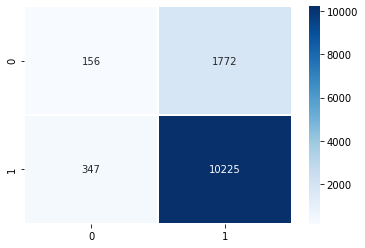

In [ ]:
y_pred = cross_val_predict(best_pipeline_tfidf, X_test, y_test, cv=3)
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat,  annot=True, cmap = 'Blues', fmt = 'g', linewidths=.5);

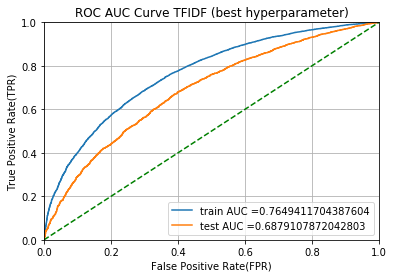

In [ ]:
roc_auc_pipe(best_pipeline_tfidf, X_train, X_test, y_train, y_test, "ROC AUC Curve TFIDF (best hyperparameter)")

In [ ]:
from prettytable import PrettyTable
t = PrettyTable(['Vectorizer', 'Model','Hyperparameter','AUC'])
t.add_row(['BOW', 'Brute', 10, 0.699])
t.add_row(['TFIDF', 'Brute', 1, 0.687])
print(t)

+------------+-------+----------------+-------+
| Vectorizer | Model | Hyperparameter |  AUC  |
+------------+-------+----------------+-------+
|    BOW     | Brute |       10       | 0.699 |
|   TFIDF    | Brute |       1        | 0.687 |
+------------+-------+----------------+-------+
